# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.223955,True,6.603665
1,-0.104736,False,-0.636171
2,1.602223,True,7.547777
3,0.113817,False,0.547770
4,-0.101027,True,4.827557
...,...,...,...
995,1.771079,True,8.978327
996,1.369655,False,3.915913
997,1.625225,True,8.920804
998,1.097352,True,6.092917


<Axes: xlabel='v0'>

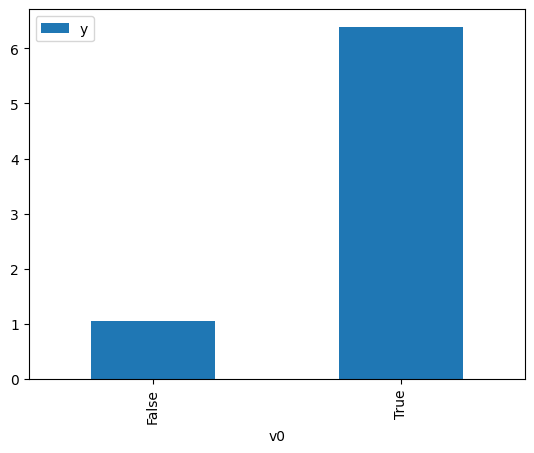

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

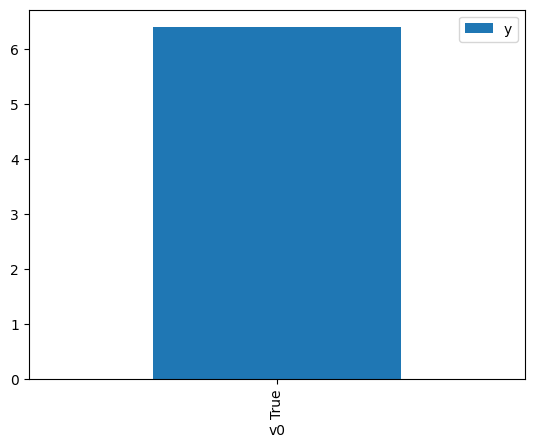

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.884499,False,-2.745716,0.685503,1.458784
1,-0.953365,False,-2.318959,0.699139,1.430330
2,-0.416359,False,-1.964042,0.585147,1.708973
3,0.128028,False,1.025915,0.459541,2.176083
4,1.235496,False,3.715268,0.232933,4.293081
...,...,...,...,...,...
995,0.649893,False,1.114471,0.343581,2.910523
996,0.130593,False,-0.810910,0.458949,2.178891
997,1.240510,False,5.062098,0.232101,4.308468
998,0.589711,False,3.784525,0.356308,2.806561


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.229571,True,5.784022,0.457533,2.185633
1,-0.079287,True,4.963895,0.492362,2.031027
2,2.485590,True,10.713690,0.913256,1.094983
3,-1.501822,True,0.391786,0.205362,4.869458
4,-0.241317,True,4.562608,0.454824,2.198652
...,...,...,...,...,...
995,1.324049,True,9.199398,0.781453,1.279668
996,0.549160,True,4.746982,0.634999,1.574805
997,0.854670,True,6.877229,0.697994,1.432678
998,0.455197,True,8.019485,0.614523,1.627279


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.740e+04
Date:                Wed, 05 Jun 2024   Prob (F-statistic):                        0.00
Time:                        15:59:37   Log-Likelihood:                         -1447.4
No. Observations:                1000   AIC:                                      2899.
Df Residuals:                     998   BIC:                                      2909.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5031      0.035     70.603      0.000       2.434       2.573
x2             5.0544      0.051     98.550      0.000       4.954       5.155
==============================================================================
Omnibus:                        5.679   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.723
Skew:                           0.145   Prob(JB):                       0.0572
Kurtosis:                       3.230   Cond. No.                         2.18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""